In [1]:
# モジュールインポート
import tensorflow as tf
import tensorflow.keras.layers as kl
import os
import numpy as np
import matplotlib.pyplot as plt

# 環境変数の上書き(INFOとWARNINGが出なくなる)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# 残差ユニット(PreActivation)の定義
class Res_Block_Pre(tf.keras.Model):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        bneck_channels = out_channels // 4

        self.bn1 = kl.BatchNormalization() #BatchNormalization
        self.av1 = kl.Activation(tf.nn.relu) #活性化関数の設定(ReLU)
        self.conv1 = kl.Conv2D(bneck_channels, kernel_size=1,
                                strides=1, padding='valid', use_bias=False) #1x1畳み込み層

        self.bn2 = kl.BatchNormalization() #BatchNormalization
        self.av2 = kl.Activation(tf.nn.relu) #活性化関数の設定(ReLU)
        self.conv2 = kl.Conv2D(bneck_channels, kernel_size=3,
                                strides=1, padding='same', use_bias=False) #3x3畳み込み層

        self.bn3 = kl.BatchNormalization() #BatchNormalization
        self.av3 = kl.Activation(tf.nn.relu) #活性化関数の設定(ReLU)
        self.conv3 = kl.Conv2D(out_channels, kernel_size=1,
                                strides=1, padding='valid', use_bias=False) #1x1畳み込み層

        self.shortcut = self._scblock(in_channels, out_channels) #shortcut connectionの設定
        self.add = kl.Add()

    # Shortcut Connection
    def _scblock(self, in_channels, out_channels):
        if in_channels != out_channels:
            self.bn_sc1 = kl.BatchNormalization()
            self.conv_sc1 = kl.Conv2D(out_channels, kernel_size=1,
                                        strides=1, padding='same', use_bias=False)
            return self.conv_sc1
        else:
            return lambda x: x #恒等写像を返す
    
    # 一連の残差ユニットの実行
    def call(self, x):
        out_1 = self.conv1(self.av1(self.bn1(x)))
        out_2 = self.conv2(self.av2(self.bn2(out_1)))
        out_3 = self.conv3(self.av3(self.bn3(out_2)))
        shortcut = self.shortcut(x)
        out_4 = self.add([out_3, shortcut])

        return out_4

In [3]:
# ResNet50(PreActivation)クラスの定義
class ResNet_Pre(tf.keras.Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()

        self._layers = [

            kl.BatchNormalization(),
            kl.Activation(tf.nn.relu),
            kl.Conv2D(64, kernel_size=7, strides=2, padding="same", use_bias=False, input_shape=input_shape),
            kl.MaxPool2D(pool_size=3, strides=2, padding="same"),
            Res_Block_Pre(64, 256),
            [
                Res_Block_Pre(256, 256) for _ in range(2)
            ],
            kl.Conv2D(512, kernel_size=1, strides=2),
            [
                Res_Block_Pre(512, 512) for _ in range(4)
            ],
            kl.Conv2D(1024, kernel_size=1, strides=2, use_bias=False),
            [
                Res_Block_Pre(1024, 1024) for _ in range(6)
            ],
            kl.Conv2D(2048, kernel_size=1, strides=2, use_bias=False),
            [
                Res_Block_Pre(2048, 2048) for _ in range(3)
            ],
            kl.GlobalAveragePooling2D(),
            kl.Dense(1000, activation="relu"),
            kl.Dense(output_dim, activation="softmax")
        ]

    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for _layer in layer:
                    x = _layer(x)
            else:
                x = layer(x)

        return x

In [4]:
# 残差ユニット(PostActivation)の定義
class Res_Block_Post(tf.keras.Model):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        bneck_channels = out_channels // 4

        self.bn1 = kl.BatchNormalization() #BatchNormalization
        self.av1 = kl.Activation(tf.nn.relu) #活性化関数の設定(ReLU)
        self.conv1 = kl.Conv2D(bneck_channels, kernel_size=1,
                                strides=1, padding='valid', use_bias=False) #1x1畳み込み層

        self.bn2 = kl.BatchNormalization() #BatchNormalization
        self.av2 = kl.Activation(tf.nn.relu) #活性化関数の設定(ReLU)
        self.conv2 = kl.Conv2D(bneck_channels, kernel_size=3,
                                strides=1, padding='same', use_bias=False) #3x3畳み込み層

        self.bn3 = kl.BatchNormalization() #BatchNormalization
        self.av3 = kl.Activation(tf.nn.relu) #活性化関数の設定(ReLU)
        self.conv3 = kl.Conv2D(out_channels, kernel_size=1,
                                strides=1, padding='valid', use_bias=False) #1x1畳み込み層

        self.shortcut = self._scblock(in_channels, out_channels) #shortcut connectionの設定
        self.add = kl.Add()

    # Shortcut Connection
    def _scblock(self, in_channels, out_channels):
        if in_channels != out_channels:
            self.bn_sc1 = kl.BatchNormalization()
            self.conv_sc1 = kl.Conv2D(out_channels, kernel_size=1,
                                        strides=1, padding='same', use_bias=False)
            return self.conv_sc1
        else:
            return lambda x: x #恒等写像を返す
    
    # 一連の残差ユニットの実行(PreActivationとの相違点はここ)
    def call(self, x):
        out_1 = self.av1(self.bn1(self.conv1(x)))
        out_2 = self.av2(self.bn2(self.conv2(out_1)))
        out_3 = self.bn3(self.conv3(out_2))
        shortcut = self.shortcut(x)
        out_4 = self.av3(self.add([out_3, shortcut]))

        return out_4

In [5]:
# ResNet50(PostActivation)クラスの定義
class ResNet_Post(tf.keras.Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()

        self._layers = [

            kl.Conv2D(64, kernel_size=7, strides=2, padding="same", use_bias=False, input_shape=input_shape),
            kl.BatchNormalization(),
            kl.Activation(tf.nn.relu),
            kl.MaxPool2D(pool_size=3, strides=2, padding="same"),
            Res_Block_Post(64, 256),
            [
                Res_Block_Post(256, 256) for _ in range(2)
            ],
            kl.Conv2D(512, kernel_size=1, strides=2),
            [
                Res_Block_Post(512, 512) for _ in range(4)
            ],
            kl.Conv2D(1024, kernel_size=1, strides=2, use_bias=False),
            [
                Res_Block_Post(1024, 1024) for _ in range(6)
            ],
            kl.Conv2D(2048, kernel_size=1, strides=2, use_bias=False),
            [
                Res_Block_Post(2048, 2048) for _ in range(3)
            ],
            kl.GlobalAveragePooling2D(),
            kl.Dense(1000, activation="relu"),
            kl.Dense(output_dim, activation="softmax")
        ]

    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for _layer in layer:
                    x = _layer(x)
            else:
                x = layer(x)

        return x

In [6]:
# 学習器クラスの定義
class trainer(object):
    def __init__(self):
        # PreActivation
        self.resnet_pre = ResNet_Pre((28, 28, 1), 10)
        self.resnet_pre.build(input_shape=(None, 28, 28, 1))
        self.resnet_pre.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                            metrics=['accuracy'])
        # PostActivation
        self.resnet_post = ResNet_Post((28, 28, 1), 10)
        self.resnet_post.build(input_shape=(None, 28, 28, 1))
        self.resnet_post.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                            metrics=['accuracy'])

    def train(self, train_img, train_lab, test_img, test_lab, out_dir, batch_size, epochs):
        print("\n\n___Start training...")

        pre_his = self.resnet_pre.fit(train_img, train_lab, validation_data=(test_img, test_lab), batch_size=batch_size, epochs=epochs)
        post_his = self.resnet_post.fit(train_img, train_lab, validation_data=(test_img, test_lab), batch_size=batch_size, epochs=epochs)

        graph_output(pre_his,post_his,out_dir) #グラフ出力

        print("___Training finished\n\n")
        
        print("\n___Saving parameter...")
        self.resnet_pre.save_weights(os.path.join(out_dir,"resnet_pre.h5")) #パラメータの保存
        self.resnet_post.save_weights(os.path.join(out_dir,"resnet_post.h5")) #パラメータの保存
        
        print("___Successfully completed\n\n")

In [7]:
# accuracy, lossグラフ
def graph_output(pre_his,post_his,out_dir):
    plt.plot(pre_his.history['accuracy'],color="blue",linestyle="solid")
    plt.plot(pre_his.history['val_accuracy'],color="blue",linestyle="dashed")    
    plt.plot(post_his.history['accuracy'],color="red",linestyle="solid")
    plt.plot(post_his.history['val_accuracy'],color="red",linestyle="dashed")

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Pre','Test Pre','Train Post','Test Post'], loc='upper left')
    plt.savefig(os.path.join(out_dir, "acc_graph.jpg"))
    plt.show()

    plt.plot(pre_his.history['loss'],color="blue",linestyle="solid")
    plt.plot(pre_his.history['val_loss'],color="blue",linestyle="dashed")
    plt.plot(post_his.history['loss'],color="red",linestyle="solid")
    plt.plot(post_his.history['val_loss'],color="red",linestyle="dashed")

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Pre','Test Pre','Train Post','Test Post'], loc='upper left')
    plt.savefig(os.path.join(out_dir, "loss_graph.jpg"))
    plt.show()

=== Setting information ===
# Output folder: D:\work_space\jupyter_work\my_study\others
# Minibatch-size: 256
# Epoch: 100


___Start training...
Epoch 1/100
235/235 [==============================] - 17s 50ms/step - loss: 0.5839 - accuracy: 0.7920 - val_loss: 0.7128 - val_accuracy: 0.7865
Epoch 2/100
235/235 [==============================] - 11s 47ms/step - loss: 0.3378 - accuracy: 0.8749 - val_loss: 0.3712 - val_accuracy: 0.8651
Epoch 3/100
235/235 [==============================] - 11s 47ms/step - loss: 0.2863 - accuracy: 0.8935 - val_loss: 0.3655 - val_accuracy: 0.8672
Epoch 4/100
235/235 [==============================] - 11s 47ms/step - loss: 0.2523 - accuracy: 0.9046 - val_loss: 0.3939 - val_accuracy: 0.8581
Epoch 5/100
235/235 [==============================] - 11s 47ms/step - loss: 0.2273 - accuracy: 0.9146 - val_loss: 0.3297 - val_accuracy: 0.8855
Epoch 6/100
235/235 [==============================] - 11s 47ms/step - loss: 0.2029 - accuracy: 0.9232 - val_loss: 0.3258 - val_a

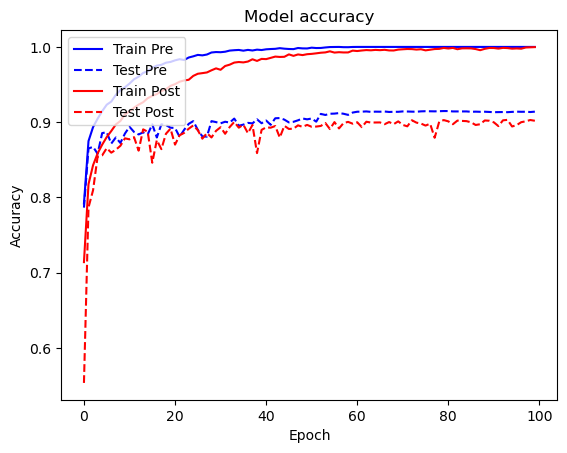

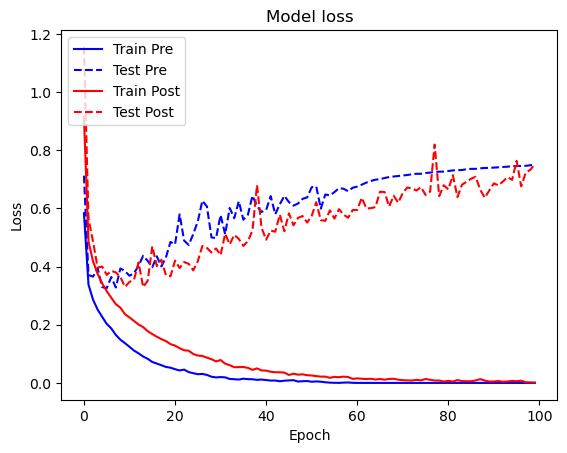

___Training finished



___Saving parameter...
___Successfully completed




In [8]:
# 学習設定
outdir = os.getcwd()
batch_size = 256
epoch = 10

# 設定情報出力
print("=== Setting information ===")
print("# Output folder: {}".format(outdir))
print("# Minibatch-size: {}".format(batch_size))
print("# Epoch: {}".format(epoch))
print("===========================")

os.makedirs(outdir, exist_ok=True)

# 使用データ読み込み(Fashion-MNIST)
f_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = f_mnist.load_data()

# 画像データの前処理
train_imgs = train_images / 255.0
train_imgs = train_imgs[:, :, :, np.newaxis]
test_imgs = test_images / 255.0
test_imgs = test_imgs[:, :, :, np.newaxis]

# 学習の実行
Trainer = trainer()
Trainer.train(train_imgs, train_labels, test_imgs, test_labels, outdir, batch_size, epoch)